ADVANCED TOPICS IN MACHINE LEARNING

Assignment - 3

Ιπποκράτης Κοτσάνης - 131

Φιλίτσα-Ιωάννα Κουσκουβέλη - 125

PART B

Links used:

  https://rowannicholls.github.io/python/data/sklearn_datasets/diabetes.html


# Imports

In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.9 MB/s eta 0:00:00


In [2]:
import random

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interactive, fixed

import pandas as pd
import shap

# Functions

In [3]:
def whiteBoxModel(X_train, X_test, y_train, y_test):
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    pred_prob_test = model.predict_proba(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return model, mse, mae, y_pred, pred_prob_test


def blackBoxModel(X_train, X_test, y_train, y_test):
    
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return model, mse, mae
     

def plotVarImp(coefs, feature_names, wb_flag, xLabel='', yLabel='', title=''):
    
    sorted_indices = coefs.argsort()    
    if wb_flag:
        sorted_features = [feature_names[i] for i in sorted_indices[0]]
        plt.barh(sorted_features, coefs[0][sorted_indices][0])
    else:
        sorted_features = [feature_names[i] for i in sorted_indices]
        plt.barh(sorted_features, coefs[sorted_indices])
    
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    plt.show()
    plt.clf()
    plt.close()
    

def plotSensor(instance, X_test, y_test, predicted_test, model, feature_names):
    random_instance = X_test[instance]
    print("Original Value:", y_test[instance], "+ Predicted Value:", predicted_test[instance])
    weights = model.coef_
    summation = sum(weights[0] * random_instance)
    bias = model.intercept_[0]
    res = summation + bias
    print("Sum(weights*instance): " + str(summation) + " + Intercept (Bias): " + str(bias) + " = " + str(res))
    model_weights = pd.DataFrame({'features': list(feature_names), 'weights*values': list(weights[0] * random_instance)})
    model_weights = model_weights.reindex(model_weights['weights*values'].abs().sort_values(ascending=False).index)  # Sort by absolute value
    model_weights = model_weights[model_weights["weights*values"] != 0]
    print("Number of features:", len(model_weights.values))
    plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
    sns.barplot(x="weights*values", y="features", data=model_weights)
    plt.xticks(rotation=90)
    plt.show()
    plt.clf()
    plt.close()


def plotShapValues(model, feature_names, X_test):

    shap.initjs()
    e = shap.TreeExplainer(model, feature_names=list(feature_names))
    shap_values = e.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names = list(feature_names))
    plt.clf()
    plt.close()
   

def plotShapVal(model, feature_names, X_test, random_instance):   
    # Calculate Shapley values
    explainer = shap.Explainer(model, X_test)
    shap_values = explainer.shap_values(random_instance)
    
    # Reshape the random_instance and shap_values arrays
    random_instance_reshaped = random_instance.reshape((1, -1))
    shap_values_reshaped = shap_values.reshape((1, -1))
    
    # Summary plot of Shapley values
    shap.summary_plot(shap_values_reshaped, random_instance_reshaped, feature_names=feature_names)


def plotShapValInteractive(instance):
    random_instance = X_test[instance]
    plotShapVal(bb, feature_names, X_test, random_instance)


   

# Import data - Split train-test sets 

In [4]:
    # Load the diabetes dataset
    diabetes = load_diabetes()

    # Description of the dataset
    print(diabetes['DESCR'])

    feature_names = diabetes.feature_names
    X, y = diabetes.data, diabetes.target
    #print(type(X),type(y)); print(X.shape, y.shape)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # An example to use for interpretability
    idx = random.randrange(10, len(X_test))
    random_instance = X_test[idx]
    true_label = y_test[idx]
    random_range = ( (idx-10), idx)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

# White Box Vs Black Box

In [5]:
    # White box model
    wb, wb_mse, wb_mae, y_pred, pred_prob_test = whiteBoxModel(X_train, X_test, y_train, y_test)
    print('wb mse: ', wb_mse, 'wb mae: ', wb_mae)  
    
    # Black box model
    bb,  bb_mse, bb_mae = blackBoxModel(X_train, X_test, y_train, y_test)
    print('bb mse: ', bb_mse, 'bb mae: ', bb_mae)  

wb mse:  5691.91011235955 wb mae:  61.640449438202246
bb mse:  3032.0427730337074 bb mae:  44.30112359550562


Παρατηρείται πως τόσο το mse όσο και το mae του White Box model (aka του Logistic Regression model) είναι χαμηλότερα και του mse και του mae του Black Box model (aka του Random Forest model). Κατα συνέπεια, το Black Box πετυχαίνει 
μεγαλύτερη ορθότητα πρόβλεψης από το White Box.

# White Box (aka Logistic Regression)

**Global Interpretation**

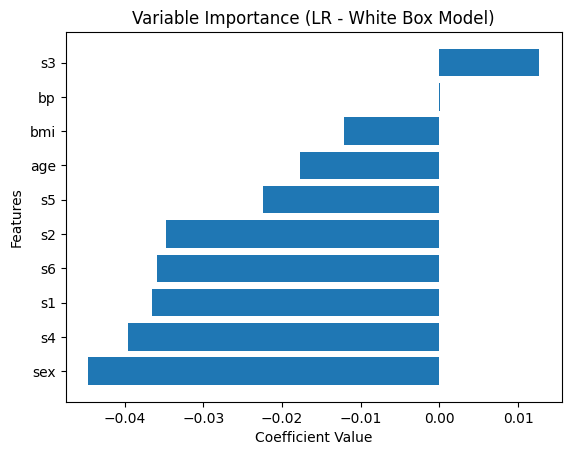

In [6]:
    # WB: GI - Variable Importance
    wb_coefs = wb.coef_
    plotVarImp(wb_coefs, feature_names, wb_flag=True, xLabel='Coefficient Value', yLabel='Features', title='Variable Importance (LR - White Box Model)')

Στο παραπάνω ραβδόγραμμα παρουσιάζονται οι συντελεστές (βάρη) του μοντέλου λογιστικής παλινδρόμησης σε φθίνουσα διάταξη σημασίας-βαρύτητας. Οι περισσότερο βαρύνοντες παράγοντες (για τον υπολογισμό του ποσοτικού δείκτης εξέλιξης της νόσου) φαίνονται να είναι (κατα απόλυτη τιμή) η μεταβλητή sex, η s4 (tch, total cholesterol / HDL), η s1 (tc, total serum cholesterol) και η s6 (glu, blood sugar level).

**Local Interpretation**

In [7]:
    # WB: LI 
    '''
    white_box_prediction = wb.predict([random_instance])
    white_box_local_interpretation = f"The white box model predicted a value of {white_box_prediction[0]} for the example with a true value of {true_label}."
    print(white_box_local_interpretation)
    '''

    inter = interactive(
        plotSensor,
        instance= random_range,
        X_test=fixed(X_test),
        y_test=fixed(y_test),
        predicted_test=fixed(y_pred),
        model=fixed(wb),
        feature_names=fixed(feature_names)
    )
    display(inter)
    #plotSensor(idx, X_test, y_test, y_pred, wb, feature_names)    

interactive(children=(IntSlider(value=24, description='instance', max=29, min=19), Output()), _dom_classes=('w…

Διατρέχοντας τις μεμονομένες τυχαίες εγγραφές, διαπιστώνεται ότι, σε πολλές απο αυτές, 3/4 πιο σημαντικούς παράγοντες που επηρεάζουν την target value ανήκουν στο σύνολο {sex, s4, s1, s6}. 

Επομένως, η τοπική ερμηνεία του μοντέλου συμπληρώνει και επιβεβαιώνει την καθολική.



# Black Box (aka Random Forest)

**Global Interpretation**

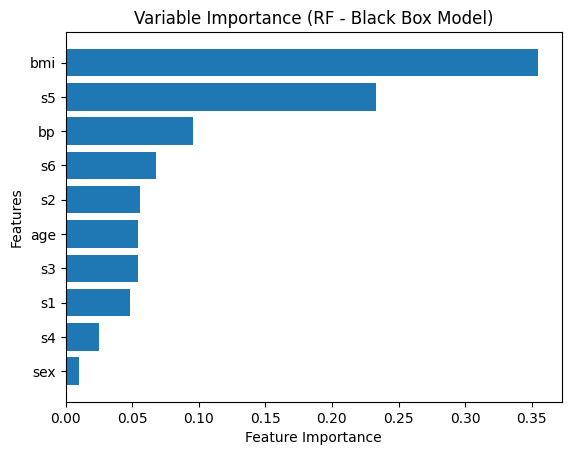

In [8]:
    # BB: GI - Variable Importance
    importances = bb.feature_importances_
    plotVarImp(importances, feature_names, wb_flag=False, xLabel='Feature Importance', yLabel='Features', title='Variable Importance (RF - Black Box Model)')

Στο παραπάνω ραβδόγραμμα παρουσιάζονται τα feature importances του μοντέλου random forest (decision trees' ensemble) σε φθίνουσα διάταξη σημασίας-βαρύτητας. Οι περισσότερο βαρύνοντες παράγοντες, σε αντίθεση με το μοντέλο λογιστικής παλινδρόμησης, (για τον υπολογισμό του ποσοτικού δείκτης εξέλιξης της νόσου) φαίνονται να είναι (κατα απόλυτη τιμή) η bmi (body mass index), s5 (ltg, possibly log of serum triglycerides level), η bp (average blood pressure) και η s6 (glu, blood sugar level).

**Local Interpretation**

The black box model predicted a value of 106.68 for the example with a true label of 107.0.


interactive(children=(IntSlider(value=24, description='instance', max=29, min=19), Output()), _dom_classes=('w…

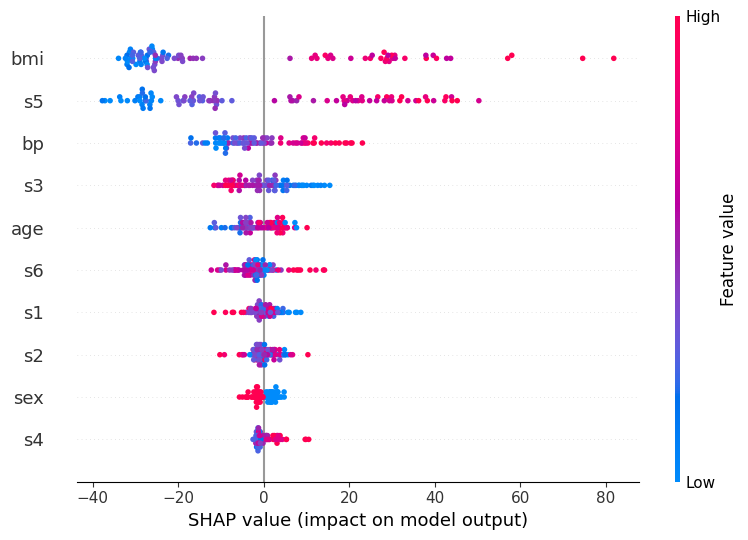

In [9]:
    # Local interpretation for the black box model
    black_box_prediction = bb.predict([random_instance])
    black_box_local_interpretation = f"The black box model predicted a value of {black_box_prediction[0]} for the example with a true label of {true_label}."
    print(black_box_local_interpretation)
    
    #plotShapVal(bb, feature_names, X_test, random_instance)
    inter = interactive(
        plotShapValInteractive,
        instance=random_range,
    )

    display(inter)

    plotShapValues(bb, feature_names, X_test)


Διατρέχοντας τις μεμονομένες τυχαίες εγγραφές (οι οποίες είναι οι ιδιες με εκείνες που παρουσιάζονται στη Logistic Regression), διαπιστώνεται ότι, σταθερά, 3/4 πιο σημαντικούς παράγοντες που επηρεάζουν την target value είναι ανήκουν στο σύνολο {bmi, s5, bp, s6}. 

Επομένως, η τοπική ερμηνεία του μοντέλου συμπληρώνει και επιβεβαιώνει την καθολική.